# Noteboook for tp24 verification with climate statistics
## Verification of deterministic forecasts using climate percentiles
(requires to run notebook_get_forecast_single.ipynb first if you want to assess your own set of forecasts)


Assessing precipitation forecasts against observations using a local climatology for score computation. 

In [1]:
import time
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from utils.utils_data  import get_obs
from utils.utils_data  import get_fct

from utils.utils_data  import get_domain
from utils.utils_stats  import get_weights

from utils.utils_scores import get_CT
from utils.utils_plots  import plot_scores

### 1. Settings

In [3]:
# where the data sit or will sit
path_data     = "/my/data/folder/seeps4all/"
path_data     = "/ec/res4/scratch/mozb/hackathon/tp24"
path_data     = "/perm/mozb/RODEO/SEEPS4ALL/DATA_RR/"

# forecasts
name_forecasts = [
                  "fct_od_0001_tp_europe_20231201_to_20240229_0_ecad",
                  "fct_ml_aifs_tp_europe_20231201_to_20240229_0_ecad",
                  "fct_ml_dmgc_tp_europe_20231201_to_20240229_0_ecad"
                 ]
name_forecasts = [
                  "fct_od_0001_tp_europe_20240301_to_20240531_0_ecad",
                  "fct_ml_aifs_tp_europe_20240301_to_20240531_0_ecad",
                  "fct_ml_dmgc_tp_europe_20240301_to_20240531_0_ecad"
                 ]
name_forecasts = [
                  "fct_od_0001_tp_europe_20240601_to_20240831_0_ecad",
                  "fct_ml_aifs_tp_europe_20240601_to_20240831_0_ecad",
                  "fct_ml_dmgc_tp_europe_20240601_to_20240831_0_ecad"
                 ]
name_forecasts = [
                  "fct_od_0001_tp_europe_20240901_to_20241130_0_ecad",
                  "fct_ml_aifs_tp_europe_20240901_to_20241130_0_ecad",
                  "fct_ml_dmgc_tp_europe_20240901_to_20241130_0_ecad"
                 ]

# colours and names 
colors = ["tab:red","darkred","tab:blue"]
labels = ["IFS", "AIFS", "GraphCast"]

# ouput path and prefix
prefig = "./prefix"


### 2. Read observations (+ metadata, + climate) and forecasts

In [4]:
# open data
obs_data = get_obs(path_data,"clim")
fct_data = get_fct(path_data,name_forecasts)

open: /perm/mozb/RODEO/SEEPS4ALL/DATA_RR//obs_clim_tp24_2022_2024_ecad.zarr
... total number of observation locations: 10562
open: /perm/mozb/RODEO/SEEPS4ALL/DATA_RR//fct_od_0001_tp_europe_20231201_to_20240229_0_ecad.zarr
Number of forecast steps: 10
Number of forecast runs: 91
open: /perm/mozb/RODEO/SEEPS4ALL/DATA_RR//fct_ml_aifs_tp_europe_20231201_to_20240229_0_ecad.zarr
Number of forecast steps: 10
Number of forecast runs: 91
open: /perm/mozb/RODEO/SEEPS4ALL/DATA_RR//fct_ml_dmgc_tp_europe_20231201_to_20240229_0_ecad.zarr
Number of forecast steps: 10
Number of forecast runs: 91


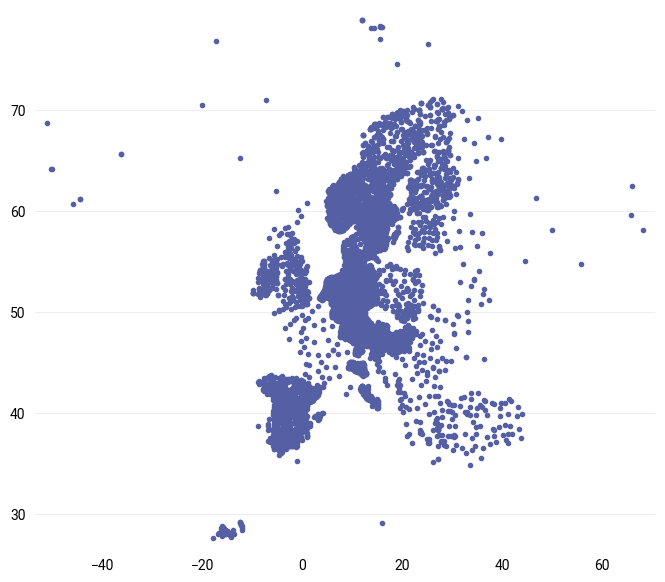

In [5]:
lat = obs_data.lat.values
lon = obs_data.lon.values
plt.plot(lon,lat,".")

experiment 0, 10 steps


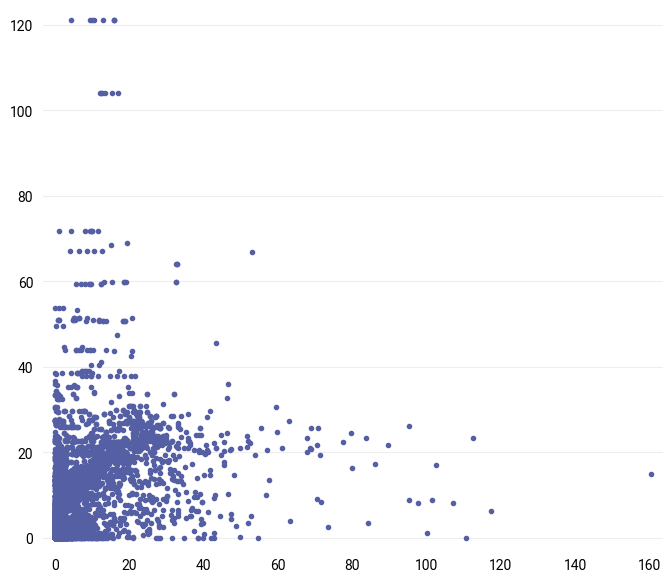

In [6]:
# scatter plot
iex = 0
istep = 0
if True:
    runs = fct_data[iex].run.values
    steps = fct_data[iex].step.values

    print(f"experiment {iex}, {len(steps)} steps")
        
    vtime = [pd.Timestamp(vt)-pd.Timedelta(24,unit="h") for vt in runs+steps[istep] ]
    valid_t = ["%s-%02d-%02d"%(vt.year,vt.month,vt.day) for vt in vtime]

    # select observations
    o = obs_data.sel(time=valid_t)

    # select ensemble
    f = fct_data[iex].sel(step=steps[istep])

f0 = f.forecast.values[0,:]
o0 = o.observation.values[0,:]
plt.plot(o0,f0,'.')

### 3. Domain and station weighting 

In [7]:
# verification domain
domain = "europe" # default otherwise define
obs_data,fct_data = get_domain(obs_data,fct_data,domain)

focus on domain europe


In [8]:
# weighting: "uniform" or "station_weighting"
weights = get_weights(obs_data,"station_weighting")

weights based on station density


### 4. Compute  threshold dependent scores

Compute PSS, ETS, FBI for a given threshold over a verification period for each forecast lead time

In [9]:
# percentiles used as thresholds
thresholds = ("perc65","perc70","perc75","perc80","perc85","perc90","perc95","perc98","perc99") 
#get contingency tables
CT = get_CT(obs_data,fct_data, weights,thresholds)

experiment 0, 10 steps
step: 0 1 2 3 4 5 6 7 8 9 
experiment 1, 10 steps
step: 0 1 2 3 4 5 6 7 8 9 
experiment 2, 10 steps
step: 0 1 2 3 4 5 6 7 8 9 


In [10]:
# info for plotting
plot_info= dict()
plot_info["thresholds"] = thresholds
plot_info["prefig"] = prefig
plot_info["colors"] = colors
plot_info["labels"] = labels

Plots as a function of the lead time

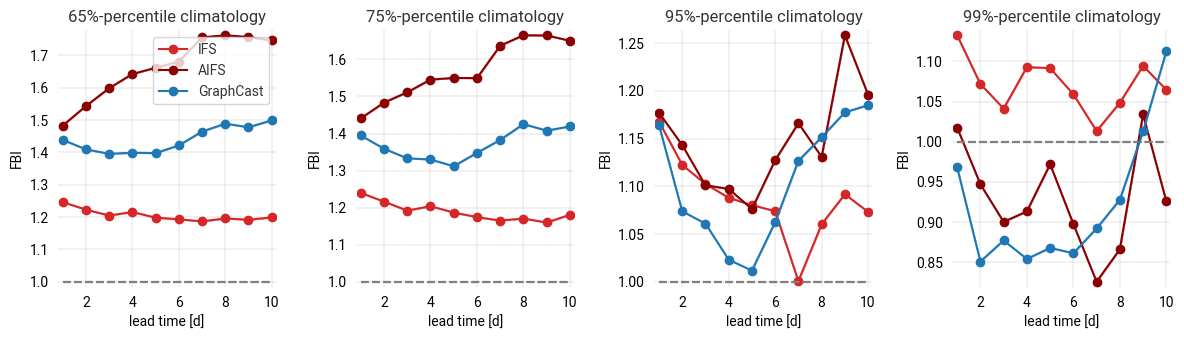

In [11]:
plot_scores(CT,"FBI",plot_info,along="step",x_list=[0,2,6,8],bootstrap=False)

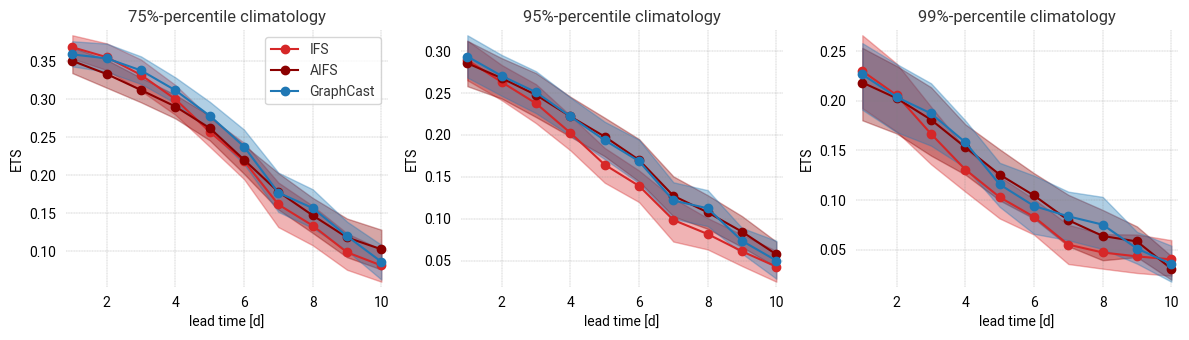

In [12]:
plot_scores(CT,"ETS",plot_info,along="step",x_list=[2,6,8],bootstrap=True)

In [13]:
#plot_scores(CT,"ETS difference",plot_info,along="step",x_list=[0,2,6,8])

In [14]:
#plot_scores(CT,"ETS relative gain",plot_info,along="step",x_list=[0,2,6,8])

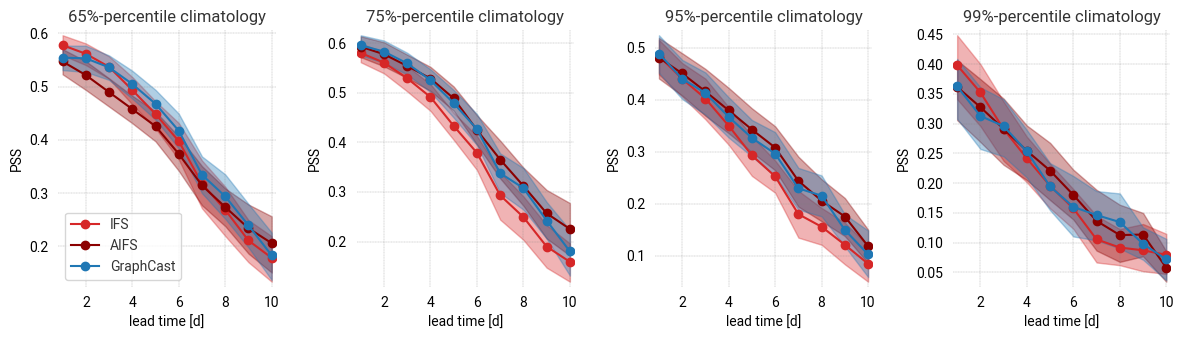

In [15]:
plot_scores(CT,"PSS",plot_info,along="step",x_list=[0,2,6,8])

In [16]:
#plot_scores(CT,"PSS difference",plot_info,along="step",x_list=[0,2,6,8])

Plots as a function of the threshold

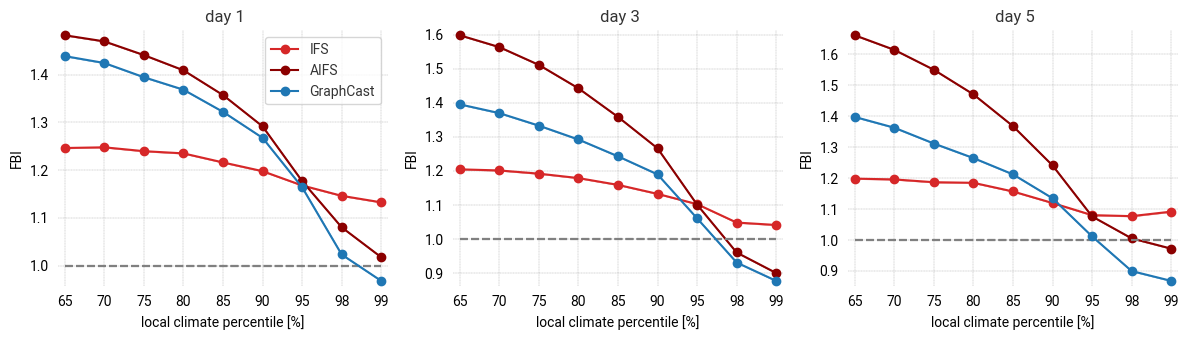

In [17]:
plot_scores(CT,"FBI",plot_info,along="thresholds",x_list=[0,2,4],bootstrap=False)

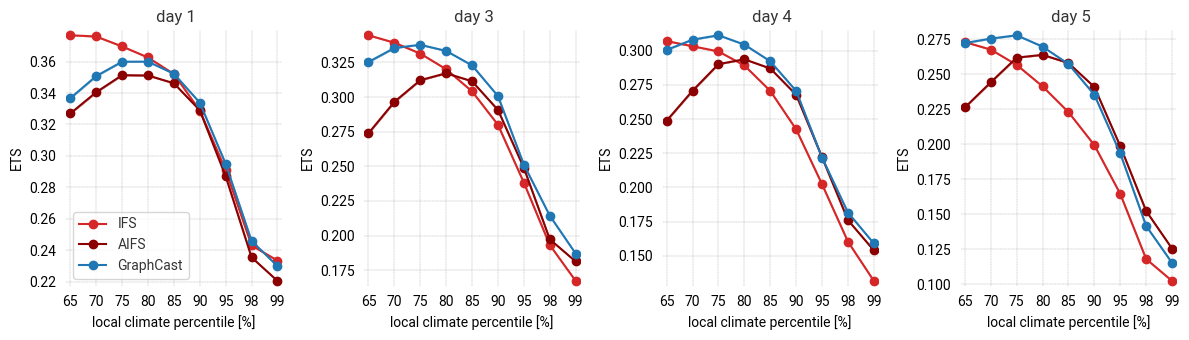

In [18]:
plot_scores(CT,"ETS",plot_info,along="thresholds",x_list=[0,2,3,4],bootstrap=False)

In [19]:
#plot_scores(CT,"ETS difference",plot_info,along="thresholds",x_list=[0,2,4])

In [20]:
#plot_scores(CT,"ETS skill",plot_info,along="thresholds",x_list=[0,2,4])

In [21]:
#plot_scores(CT,"ETS relative gain",plot_info,along="thresholds",x_list=[0,2,4])

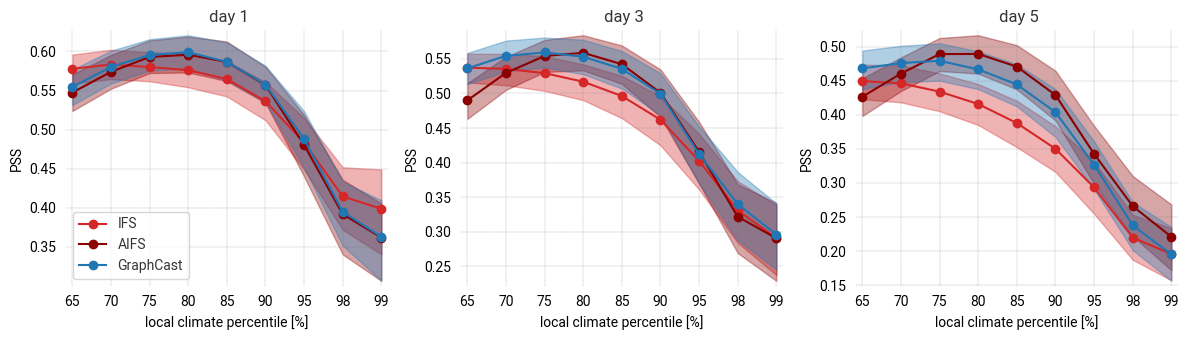

In [22]:
plot_scores(CT,"PSS",plot_info,along="thresholds",x_list=[0,2,4])

In [23]:
#plot_scores(CT,"PSS difference",plot_info,along="thresholds",x_list=[0,2,4])

In [24]:
#plot_scores(CT,"PSS relative gain",plot_info,along="thresholds",x_list=[0,2,4])

End of the Notebook